# Analisis de RNA-seq
¡Requerido activar ambiente miniconda en servidor dedicado *RNAseq*! \
Explora los ambientes disponibles con **conda env list**  

En el *práctico 2* se utilizó el software **fastq_screen** como un primer control de calidad para mapear los reads en formato fastq frente a un conjunto de genomas de referencia y lograr identificar su origen

In [ ]:
# Ejecutar en cluster dedicado
fastq_screen ../../../data/rnaseq_MTWT/*.fastq --outdir ./

Luego se ejecutó **FASTQC** para generar reportes de calidad de los datos de secuenciación para poder indentificar posibles problemas de lectura y contenido. Importante en el preprocesamiento de los datos

In [ ]:
fastqc ../../data/rnaseq_MTWT/*.fastq -o ./

### **Pre-procesamiento de RNA-seq**
Prueba inicial para corte de adaptadores y filtrado de secuencias utilizando CutAdapt 5.1 con Python 3.10.18 siguiendo la siguiente línea de comandos.\
> **Nota:**\
> La lista de adaptadores y de posibles contaminantes fue obtenida de \
> https://support-docs.illumina.com/SHARE/AdapterSequences/Content/SHARE/AdapterSeq/Nextera/SequencesNextera_Illumina.htm

In [ ]:
# Ejecución de la linea de comandos sobre ambiente miniconda con los programas respectivos instalados

cutadapt -a CTGTCTCTTATACACATCT -A CTGTCTCTTATACACATCT --action trim -u -2 -U -2 \
-q 30 -Q 30 --poly-a --trim-n --pair-filter=any --minimum-length 50 \
-o WT1_R1_out.fastq -p WT1_R2_out.fastq ../../data/rnaseq_MTWT/WT1_Pax6_R1_subset.fastq ../../data/rnaseq_MTWT/WT1_Pax6_R2_subset.fastq > reportWT1.txt

Siempre ejecutar **FastQC** para verificar la calidad del filtrado y modificaciones de los reads

In [ ]:
fastqc *.fastq -o quality_ctrl/

### **Alineamiento de secuencias**

**¿Qué es un archivo GTF?**
El **GTF (Gene Transfer Format)** es un archivo de texto tabulado utilizado para almacenar **anotaciones genómicas** como genes, transcritos, exones, CDS y UTRs.  
Es una variante estandarizada de **GFF2**, diseñada específicamente para representar estructuras génicas y transcriptómicas.

---
#### **Estructura del archivo**

Cada línea (excepto comentarios que comienzan con `#`) contiene **9 columnas obligatorias**:

1. **seqname** → Cromosoma/contig (ej. `chr1`, `MT`).  
2. **source** → Fuente de la anotación (ej. `ENSEMBL`, `HAVANA`).  
3. **feature** → Tipo de elemento (`gene`, `transcript`, `exon`, `CDS`, etc.).  
4. **start** → Posición inicial (*1-based, inclusive*).  
5. **end** → Posición final (*1-based, inclusive*).  
6. **score** → Valor numérico o `.` si no aplica.  
7. **strand** → Hebra (`+`, `-`, o `.`).  
8. **frame** → Fase de codón (`0`, `1`, `2`, o `.`).  
9. **attributes** → Pares clave-valor con metadatos.
---
#### **Ejemplo**

```txt
chr19    HAVANA    exon    409006    409170    .    -    .    gene_id "ENSG00000183186.7"; transcript_id "ENST00000332235.7"; exon_number 1; gene_name "C2CD4C";

In [ ]:
#! /bin/bash
# Script para automatización del alineamiento utilziando HiSat2

# Bucle infinito: se ejecuta hasta que el usuario decida salir con 'exit'
while true; do

    # Solicitar Identificador 1 (ej: WT1, WT2)
    read -p "Introduce el Identificador 1 (ID1, ej: WT1/MUT1): " ID1

    # --- 2. CONDICIÓN DE SALIDA ---
    # Si ambos inputs es 'exit', el script termina.
    if [[ "$ID1" == "exit" ]]; then
        echo "--------------------------------------------------------"
        echo "¡Proceso terminado por el usuario. Saliendo del script!"
        echo "--------------------------------------------------------"
        break
    fi

    # --- 3. EJECUCIÓN DEL COMANDO CUTADAPT ---
    echo "--------------------------------------------------------"
    echo "Ejecutando Hisat2 con ID1: $ID1 ..."

    hisat2 -x "../../data/Danio_rerio_114/Danio_rerio.GRCz11.dna.toplevel" -1 "../preprocess_seq/${ID1}_R1_out.fastq" \
    -2 "../preprocess_seq/${ID1}_R2_out.fastq" -S "mapped_${ID1}.sam" -q \
    --known-splicesite-infile "../../data/Danio_rerio_114/Danio_rerio.GRCz11.114.ss" &> "report${ID1}.txt"
    # Notificar al usuario el estado de la ejecución
    if [ $? -eq 0 ]; then
        echo "Comando ejecutado exitosamente."
        echo "Reporte generado: report${ID1}.txt"
    else
        echo "¡ERROR! El comando cutadapt falló en esta iteración."
    fi
    echo "--------------------------------------------------------"
done

Los archivos .sam generados en el alineamiento inicialmente fueron convertidos a archivos .bam en el caso de que se necesitara.\
Se ordenó el mapeo realizado anteriormente con HiSat2 y se generó el reporte del alineamiento utilizando flagstat


In [ ]:
#! /bin/bash

# Conda environment activation
source ~/miniconda3/etc/profile.d/conda.sh 
conda activate samtools

# Sorting and report generation from alignment files
conditions=("WT1" "WT2" "WT3" "MUT1" "MUT2" "MUT3")
base_route="/home/gbernal/run/alignment"

# Files creations
mkdir -p sorted stats

echo "--- Ejecución de conversion inicial ---"

for condition in "${conditions[@]}"; do
    samtools sort "${base_route}/mapped_${condition}.sam" -o "sorted/mapped_sort_${condition}.bam"
    samtools flagstat "sorted/mapped_sort_${condition}.bam" > "stats/report${condition}.txt"

    echo "--- Comando finalizado para ${condition} ---"

done

conda deactivate


Generar gráficos para comunicar reportes de alineamiento generados


Resumen extraído de los reportes:
           Total_reads  Mapped_reads  Mapped_percent  Properly_paired  \
Condition                                                               
WT1          1962365.0     1760945.0           89.74        1411052.0   
WT2          1911337.0     1730273.0           90.53        1347734.0   
WT3          1897991.0     1720690.0           90.66        1337154.0   
MUT1         2104835.0     1924837.0           91.45        1359544.0   
MUT2         2014068.0     1837227.0           91.22        1321234.0   
MUT3         2016596.0     1824529.0           90.48        1438780.0   

           Properly_paired_percent  Singletons  Singletons_percent  
Condition                                                           
WT1                          83.82     52680.0                3.13  
WT2                          84.35     49062.0                3.07  
WT3                          84.85     42971.0                2.73  
MUT1                         84.52 

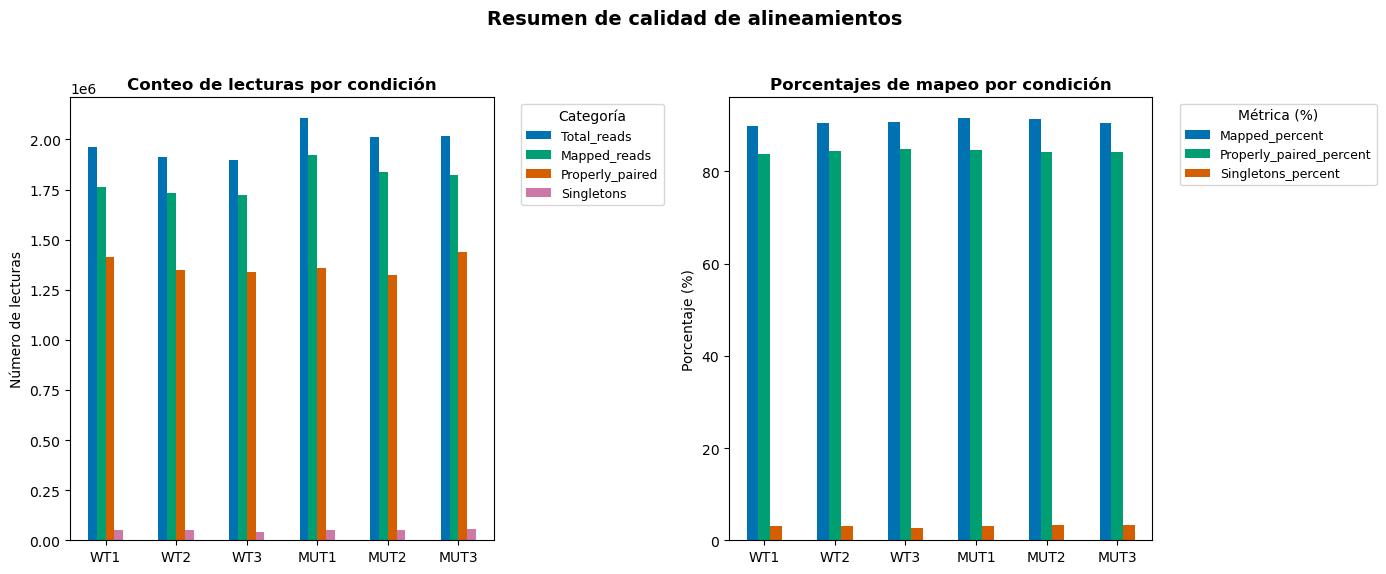

In [5]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración ---
stats_dir = "../run/alignment/stats"
conditions = ["WT1", "WT2", "WT3", "MUT1", "MUT2", "MUT3"]

# --- Función para extraer métricas desde cada archivo ---
def parse_flagstat(file_path):
    data = {
        "Total_reads": 0,
        "Mapped_reads": 0,
        "Mapped_percent": 0.0,
        "Properly_paired": 0,
        "Properly_paired_percent": 0.0,
        "Singletons": 0,
        "Singletons_percent": 0.0
    }

    with open(file_path, "r") as f:
        for line in f:
            if "in total" in line:
                data["Total_reads"] = int(line.split("+")[0].strip())
            elif "mapped (" in line and "primary mapped" not in line:
                match = re.search(r"(\d+) \+ \d+ mapped \(([\d\.]+)%", line)
                if match:
                    data["Mapped_reads"] = int(match.group(1))
                    data["Mapped_percent"] = float(match.group(2))
            elif "properly paired" in line:
                match = re.search(r"(\d+) \+ \d+ properly paired \(([\d\.]+)%", line)
                if match:
                    data["Properly_paired"] = int(match.group(1))
                    data["Properly_paired_percent"] = float(match.group(2))
            elif "singletons" in line:
                match = re.search(r"(\d+) \+ \d+ singletons \(([\d\.]+)%", line)
                if match:
                    data["Singletons"] = int(match.group(1))
                    data["Singletons_percent"] = float(match.group(2))
    return data

# --- Procesar todos los reportes ---
results = {}
for cond in conditions:
    report_path = os.path.join(stats_dir, f"report{cond}.txt")
    if os.path.exists(report_path):
        results[cond] = parse_flagstat(report_path)
    else:
        print(f"⚠️  No se encontró {report_path}")

# --- Crear DataFrame ---
df = pd.DataFrame(results).T
df.index.name = "Condition"

print("\nResumen extraído de los reportes:")
print(df)

# --- Crear figura con dos subplots ---
plt.style.use("seaborn-v0_8-colorblind")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Panel 1: conteos absolutos ---
df[["Total_reads", "Mapped_reads", "Properly_paired", "Singletons"]].plot(kind="bar", ax=axes[0])
axes[0].set_title("Conteo de lecturas por condición", fontsize=12, weight="bold")
axes[0].set_ylabel("Número de lecturas")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title="Categoría", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)

# --- Panel 2: porcentajes ---
df[["Mapped_percent", "Properly_paired_percent", "Singletons_percent"]].plot(kind="bar", ax=axes[1])
axes[1].set_title("Porcentajes de mapeo por condición", fontsize=12, weight="bold")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title="Métrica (%)", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)

plt.suptitle("Resumen de calidad de alineamientos", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("alignment_summary_panel.png", dpi=300)
plt.show()


RSeqC - Entrega parámetros de calidad del alineamiento (en este caso se utilizó GeneCoverage)

In [ ]:
#!/bin/bash

# Lista de las condiciones o tipos de muestra
conditions=("WT1" "WT2" "WT3" "MUT1" "MUT2" "MUT3")

echo "Iniciando el cálculo de cobertura de cuerpo de genes para las muestras: ${conditions[@]}"

# Itera sobre cada elemento de la lista 'conditions'
for condition in "${conditions[@]}"; do
    echo "-> Procesando muestra: ${condition}"
    
    # Ejecuta el comando, sustituyendo ${condition}
    geneBody_coverage.py \
        -i "../sorted/mapped_sort_${condition}.bam" \
        -r "../../../data/Danio_rerio_114/Danio_rerio.GRCz11.114.bed" \
        -o "genecoverage_${condition}"
    
    # Comprueba el código de salida del comando anterior ($?)
    if [ $? -eq 0 ]; then
        echo "   [OK] Archivo de salida 'genecoverage_${condition}' creado con éxito."
    else
        echo "   [ERROR] Fallo al ejecutar geneBody_coverage.py para ${condition}." >&2
    fi
done

echo "Proceso completado para todas las muestras."

Adicionalmente se realizó un conteo y estimación de genes con HT-seq

In [ ]:
#!/bin/bash

# Lista de las condiciones o tipos de muestra
conditions=("WT1" "WT2" "WT3" "MUT1" "MUT2" "MUT3")

echo "Iniciando el cálculo de estimacion de expresion de genes para las muestras: ${conditions[@]}"

# Itera sobre cada elemento de la lista 'conditions'
for condition in "${conditions[@]}"; do
    output="counts_${condition}.txt"
    echo "-> Procesando muestra: ${condition}"
    
    # Ejecuta el comando, sustituyendo ${condition}
    htseq-count  \
        --stranded="no" --idattr="gene_id" \
        "../sorted/mapped_sort_${condition}.bam" \
        "../../../data/Danio_rerio_114/Danio_rerio.GRCz11.114.gtf" \
	> "${output}"
    
    # Comprueba el código de salida del comando anterior ($?)
    if [ $? -eq 0 ]; then
        echo "   [OK] Archivo de conteo '${output}' creado con éxito."
    else
        echo "   [ERROR] Fallo al ejecutar htseq-count para ${condition}." >&2
    fi
done

echo "Proceso completado para todas las muestras."